# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = oversampling_SMOTE(join_c)
print (len(over[0]), len(over[1]), len(over[2])) 

7592 253
3796 1898 1898 126 63 64
7592 3796 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 3796, 1.0: 3796})
Counter({1.0: 1898, 0.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [28]:
learnRate = 0.01
graficoName = "oversampling SMOTE, lr=0.01, rede="

## RNA 1 (10)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.7005 - acc: 0.4506 - val_loss: 0.5639 - val_acc: 0.5037
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.4107 - acc: 0.5416 - val_loss: 0.3997 - val_acc: 0.5835
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.2624 - acc: 0.6621 - val_loss: 0.2885 - val_acc: 0.6301
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1923 - acc: 0.7184 - val_loss: 0.2307 - val_acc: 0.6768
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1603 - acc: 0.7550 - val_loss: 0.2007 - val_acc: 0.7060
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1445 - acc: 0.7953 - val_loss: 0.1842 - val_acc: 0.7497
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.1357 - acc: 0.8248 - val_loss: 0.1740 - val_acc: 0.7874
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0820 - acc: 0.9156 - val_loss: 0.0978 - val_acc: 0.8996
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0819 - acc: 0.9154 - val_loss: 0.0977 - val_acc: 0.8996
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0818 - acc: 0.9153 - val_loss: 0.0975 - val_acc: 0.8999
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0817 - acc: 0.9157 - val_loss: 0.0976 - val_acc: 0.8996
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0816 - acc: 0.9153 - val_loss: 0.0975 - val_acc: 0.8999
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0815 - acc: 0.9154 - val_loss: 0.0975 - val_acc: 0.8996
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0814 - acc: 0.9150 - val_loss: 0.0972 - val_acc: 0.8999
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0813 - acc: 0.9154 - val_loss: 0.0971 -

7592/7592 [==============================] - 0s - loss: 0.0711 - acc: 0.9222 - val_loss: 0.0839 - val_acc: 0.9060
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0711 - acc: 0.9220 - val_loss: 0.0838 - val_acc: 0.9062
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0710 - acc: 0.9222 - val_loss: 0.0836 - val_acc: 0.9062
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0709 - acc: 0.9220 - val_loss: 0.0836 - val_acc: 0.9065
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0709 - acc: 0.9219 - val_loss: 0.0835 - val_acc: 0.9067
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0708 - acc: 0.9220 - val_loss: 0.0835 - val_acc: 0.9067
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9223 - val_loss: 0.0833 - val_acc: 0.9065
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9224 - val_loss: 0.0833 -

7592/7592 [==============================] - 0s - loss: 0.0652 - acc: 0.9273 - val_loss: 0.0746 - val_acc: 0.9091
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0652 - acc: 0.9280 - val_loss: 0.0745 - val_acc: 0.9091
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0652 - acc: 0.9277 - val_loss: 0.0745 - val_acc: 0.9091
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9274 - val_loss: 0.0746 - val_acc: 0.9094
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9277 - val_loss: 0.0743 - val_acc: 0.9091
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9280 - val_loss: 0.0743 - val_acc: 0.9091
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9281 - val_loss: 0.0743 - val_acc: 0.9086
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9280 - val_loss: 0.0741 -

7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9291 - val_loss: 0.0689 - val_acc: 0.9125
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9293 - val_loss: 0.0689 - val_acc: 0.9125
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0619 - acc: 0.9294 - val_loss: 0.0689 - val_acc: 0.9125
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9294 - val_loss: 0.0688 - val_acc: 0.9125
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9291 - val_loss: 0.0688 - val_acc: 0.9128
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9294 - val_loss: 0.0688 - val_acc: 0.9128
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9297 - val_loss: 0.0688 - val_acc: 0.9131
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0618 - acc: 0.9293 - val_loss: 0.0688 -

7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9314 - val_loss: 0.0654 - val_acc: 0.9173
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9315 - val_loss: 0.0654 - val_acc: 0.9175
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9314 - val_loss: 0.0654 - val_acc: 0.9173
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9312 - val_loss: 0.0654 - val_acc: 0.9175
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9314 - val_loss: 0.0653 - val_acc: 0.9175
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9316 - val_loss: 0.0652 - val_acc: 0.9183
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0597 - acc: 0.9312 - val_loss: 0.0653 - val_acc: 0.9173
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0596 - acc: 0.9312 - val_loss: 0.0653 -

7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9337 - val_loss: 0.0621 - val_acc: 0.9191
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9340 - val_loss: 0.0621 - val_acc: 0.9197
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9337 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9340 - val_loss: 0.0620 - val_acc: 0.9197
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9339 - val_loss: 0.0620 -

7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9360 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9361 - val_loss: 0.0605 - val_acc: 0.9210
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9359 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9360 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9359 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9359 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9361 - val_loss: 0.0604 - val_acc: 0.9210
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0547 - acc: 0.9357 - val_loss: 0.0604 -

7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9373 - val_loss: 0.0598 - val_acc: 0.9215
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9373 - val_loss: 0.0598 - val_acc: 0.9223
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9374 - val_loss: 0.0598 - val_acc: 0.9220
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9370 - val_loss: 0.0597 - val_acc: 0.9223
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9374 - val_loss: 0.0597 - val_acc: 0.9226
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9370 - val_loss: 0.0597 - val_acc: 0.9226
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9374 - val_loss: 0.0597 - val_acc: 0.9226
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9376 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9391 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9393 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0.0591 - val_acc: 0.9239
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9393 - val_loss: 0.0591 - val_acc: 0.9236
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0.0590 - val_acc: 0.9236
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9393 - val_loss: 0.0591 - val_acc: 0.9233
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9394 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9407 - val_loss: 0.0587 - val_acc: 0.9236
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9409 - val_loss: 0.0586 - val_acc: 0.9236
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0506 - acc: 0.9409 - val_loss: 0.0586 - val_acc: 0.9236
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9410 - val_loss: 0.0587 - val_acc: 0.9236
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9407 - val_loss: 0.0587 - val_acc: 0.9236
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9409 - val_loss: 0.0587 - val_acc: 0.9239
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9407 - val_loss: 0.0587 - val_acc: 0.9239
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9407 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9416 - val_loss: 0.0583 - val_acc: 0.9231
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9420 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9422 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9420 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9422 - val_loss: 0.0584 - val_acc: 0.9228
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0497 - acc: 0.9418 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9419 - val_loss: 0.0583 - val_acc: 0.9228
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0496 - acc: 0.9420 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9426 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9423 - val_loss: 0.0583 - val_acc: 0.9231
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9231
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0.0581 - val_acc: 0.9233
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9427 - val_loss: 0.0583 - val_acc: 0.9231
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9423 - val_loss: 0.0582 - val_acc: 0.9233
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0490 - acc: 0.9424 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9426 - val_loss: 0.0581 - val_acc: 0.9249
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9423 - val_loss: 0.0582 - val_acc: 0.9249
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9247
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9424 - val_loss: 0.0582 - val_acc: 0.9249
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0485 - acc: 0.9427 - val_loss: 0.0581 - val_acc: 0.9249
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9423 - val_loss: 0.0582 - val_acc: 0.9249
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9427 - val_loss: 0.0581 - val_acc: 0.9249
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0484 - acc: 0.9427 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9432 - val_loss: 0.0584 - val_acc: 0.9254
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9431 - val_loss: 0.0585 - val_acc: 0.9257
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9430 - val_loss: 0.0584 - val_acc: 0.9257
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9430 - val_loss: 0.0583 - val_acc: 0.9257
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9432 - val_loss: 0.0584 - val_acc: 0.9257
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9432 - val_loss: 0.0584 - val_acc: 0.9257
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9431 - val_loss: 0.0585 - val_acc: 0.9252
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9431 - val_loss: 0

In [22]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1952/1962 [============================>.] - ETA: 0s[0.046523179560823788, 0.93628950038816583]


<IPython.core.display.Javascript object>


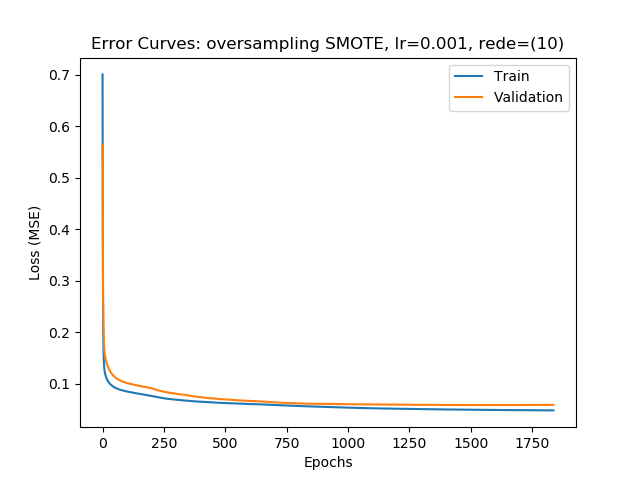

<IPython.core.display.Javascript object>


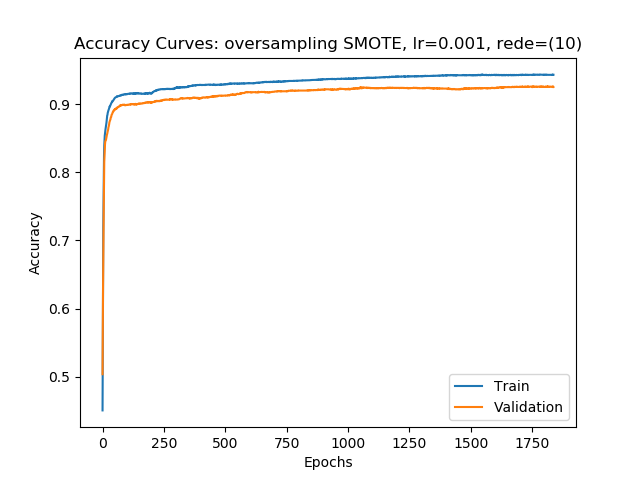

Matriz de confusão
[[1781  117]
 [   7   57]]

Train Loss:       0.0489
Validation Loss:  0.0580
Accuracy:         0.9368
MSE:              0.0632
AUROC:            0.9399


In [23]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [24]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.2796 - acc: 0.6048 - val_loss: 0.2740 - val_acc: 0.6246
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.1893 - acc: 0.7206 - val_loss: 0.2175 - val_acc: 0.7092
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.1550 - acc: 0.7578 - val_loss: 0.1913 - val_acc: 0.7289
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1395 - acc: 0.8006 - val_loss: 0.1753 - val_acc: 0.7532
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1302 - acc: 0.8193 - val_loss: 0.1642 - val_acc: 0.7835
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1235 - acc: 0.8338 - val_loss: 0.1554 - val_acc: 0.8087
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.1182 - acc: 0.8473 - val_loss: 0.1485 - val_acc: 0.8214
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9369 - val_loss: 0.0782 - val_acc: 0.9139
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9369 - val_loss: 0.0782 - val_acc: 0.9139
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9366 - val_loss: 0.0781 - val_acc: 0.9139
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9370 - val_loss: 0.0781 - val_acc: 0.9139
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9370 - val_loss: 0.0780 - val_acc: 0.9139
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9369 - val_loss: 0.0778 - val_acc: 0.9136
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9369 - val_loss: 0.0778 - val_acc: 0.9139
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9370 - val_loss: 0.0780 -

7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9407 - val_loss: 0.0714 - val_acc: 0.9170
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9416 - val_loss: 0.0713 - val_acc: 0.9170
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9413 - val_loss: 0.0712 - val_acc: 0.9170
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9414 - val_loss: 0.0713 - val_acc: 0.9170
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9415 - val_loss: 0.0712 - val_acc: 0.9170
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9414 - val_loss: 0.0711 - val_acc: 0.9175
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9414 - val_loss: 0.0711 - val_acc: 0.9170
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9413 - val_loss: 0.0710 -

7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9456 - val_loss: 0.0673 - val_acc: 0.9197
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9452 - val_loss: 0.0673 - val_acc: 0.9197
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9455 - val_loss: 0.0673 - val_acc: 0.9197
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9457 - val_loss: 0.0671 - val_acc: 0.9197
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9455 - val_loss: 0.0671 - val_acc: 0.9194
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9457 - val_loss: 0.0671 - val_acc: 0.9197
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9455 - val_loss: 0.0671 - val_acc: 0.9197
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9456 - val_loss: 0.0671 -

7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9482 - val_loss: 0.0641 - val_acc: 0.9218
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9485 - val_loss: 0.0640 - val_acc: 0.9218
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9482 - val_loss: 0.0641 - val_acc: 0.9212
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0502 - acc: 0.9484 - val_loss: 0.0640 - val_acc: 0.9210
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9486 - val_loss: 0.0640 - val_acc: 0.9218
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9484 - val_loss: 0.0640 - val_acc: 0.9215
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9484 - val_loss: 0.0640 - val_acc: 0.9218
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0501 - acc: 0.9482 - val_loss: 0.0642 -

7592/7592 [==============================] - 0s - loss: 0.0481 - acc: 0.9488 - val_loss: 0.0627 - val_acc: 0.9220
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9489 - val_loss: 0.0628 - val_acc: 0.9220
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9490 - val_loss: 0.0628 - val_acc: 0.9223
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9494 - val_loss: 0.0628 - val_acc: 0.9223
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9492 - val_loss: 0.0626 - val_acc: 0.9226
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9493 - val_loss: 0.0627 - val_acc: 0.9220
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0480 - acc: 0.9493 - val_loss: 0.0627 - val_acc: 0.9220
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0479 - acc: 0.9494 - val_loss: 0.0628 -

7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9517 - val_loss: 0.0614 - val_acc: 0.9233
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9510 - val_loss: 0.0614 - val_acc: 0.9236
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9511 - val_loss: 0.0614 - val_acc: 0.9236
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0464 - acc: 0.9514 - val_loss: 0.0614 - val_acc: 0.9233
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9511 - val_loss: 0.0615 - val_acc: 0.9231
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9515 - val_loss: 0.0615 - val_acc: 0.9233
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9513 - val_loss: 0.0612 - val_acc: 0.9233
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9514 - val_loss: 0.0613 -

7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9527 - val_loss: 0.0600 - val_acc: 0.9262
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0599 - val_acc: 0.9265
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0599 - val_acc: 0.9268
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9524 - val_loss: 0.0600 - val_acc: 0.9265
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9524 - val_loss: 0.0600 - val_acc: 0.9260
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9527 - val_loss: 0.0600 - val_acc: 0.9260
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0600 - val_acc: 0.9260
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9523 - val_loss: 0.0601 -

7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9532 - val_loss: 0.0594 - val_acc: 0.9276
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9532 - val_loss: 0.0594 - val_acc: 0.9278
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9528 - val_loss: 0.0594 - val_acc: 0.9276
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9528 - val_loss: 0.0593 - val_acc: 0.9281
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9532 - val_loss: 0.0593 - val_acc: 0.9283
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9527 - val_loss: 0.0592 - val_acc: 0.9281
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9531 - val_loss: 0.0592 - val_acc: 0.9281
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9535 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9534 - val_loss: 0.0585 - val_acc: 0.9305
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9534 - val_loss: 0.0585 - val_acc: 0.9297
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9535 - val_loss: 0.0585 - val_acc: 0.9297
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9538 - val_loss: 0.0585 - val_acc: 0.9305
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9534 - val_loss: 0.0586 - val_acc: 0.9294
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9539 - val_loss: 0.0586 - val_acc: 0.9291
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9532 - val_loss: 0.0585 - val_acc: 0.9297
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9535 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9544 - val_loss: 0.0579 - val_acc: 0.9312
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9546 - val_loss: 0.0579 - val_acc: 0.9315
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9546 - val_loss: 0.0579 - val_acc: 0.9312
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9546 - val_loss: 0.0580 - val_acc: 0.9315
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9540 - val_loss: 0.0579 - val_acc: 0.9312
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0428 - acc: 0.9542 - val_loss: 0.0579 - val_acc: 0.9315
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0427 - acc: 0.9544 - val_loss: 0.0579 - val_acc: 0.9315
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0427 - acc: 0.9546 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9550 - val_loss: 0.0577 - val_acc: 0.9323
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9547 - val_loss: 0.0576 - val_acc: 0.9328
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9548 - val_loss: 0.0577 - val_acc: 0.9326
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9546 - val_loss: 0.0576 - val_acc: 0.9326
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9548 - val_loss: 0.0576 - val_acc: 0.9328
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9547 - val_loss: 0.0575 - val_acc: 0.9326
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9547 - val_loss: 0.0576 - val_acc: 0.9326
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0422 - acc: 0.9544 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9548 - val_loss: 0.0571 - val_acc: 0.9336
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0571 - val_acc: 0.9336
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0570 - val_acc: 0.9334
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0570 - val_acc: 0.9334
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0.0571 - val_acc: 0.9334
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9551 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9548 - val_loss: 0.0571 - val_acc: 0.9336
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0416 - acc: 0.9550 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9553 - val_loss: 0.0569 - val_acc: 0.9347
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9557 - val_loss: 0.0571 - val_acc: 0.9344
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9553 - val_loss: 0.0570 - val_acc: 0.9336
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9559 - val_loss: 0.0571 - val_acc: 0.9339
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9557 - val_loss: 0.0571 - val_acc: 0.9339
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9553 - val_loss: 0.0571 - val_acc: 0.9344
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9555 - val_loss: 0.0570 - val_acc: 0.9339
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0411 - acc: 0.9557 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9555 - val_loss: 0.0572 - val_acc: 0.9341
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9557 - val_loss: 0.0570 - val_acc: 0.9341
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9555 - val_loss: 0.0570 - val_acc: 0.9347
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0.0571 - val_acc: 0.9341
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9557 - val_loss: 0.0572 - val_acc: 0.9336
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0407 - acc: 0.9556 - val_loss: 0

In [25]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1600/1962 [=======================>......] - ETA: 0s[0.038075174786963109, 0.95005096839959224]


<IPython.core.display.Javascript object>


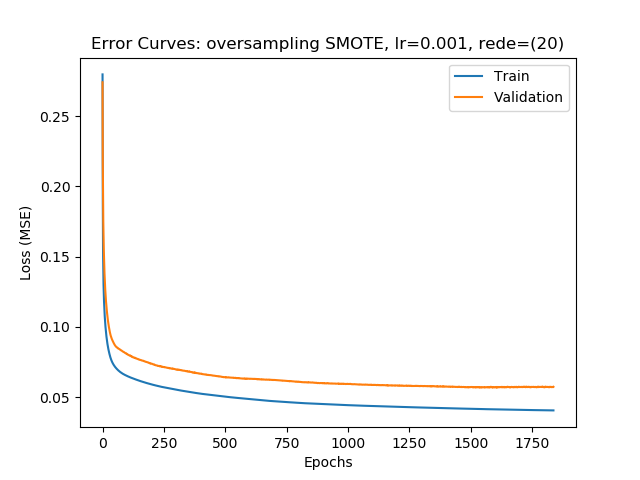

<IPython.core.display.Javascript object>


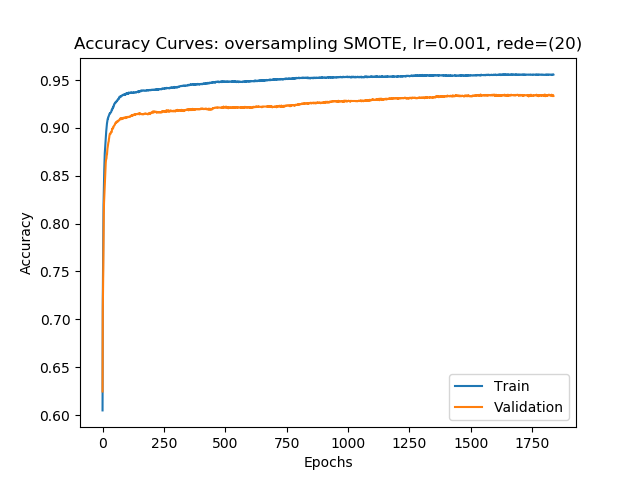

Matriz de confusão
[[1810   88]
 [   9   55]]

Train Loss:       0.0415
Validation Loss:  0.0568
Accuracy:         0.9506
MSE:              0.0494
AUROC:            0.9466


In [26]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='sigmoid', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='sigmoid')) # camada escondida
classifier.add(Dense(1, activation='sigmoid')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.2356 - acc: 0.6687 - val_loss: 0.2351 - val_acc: 0.6610
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.2321 - acc: 0.7260 - val_loss: 0.2322 - val_acc: 0.7932
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.2289 - acc: 0.8095 - val_loss: 0.2292 - val_acc: 0.8114
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.2254 - acc: 0.8369 - val_loss: 0.2260 - val_acc: 0.8014
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.2218 - acc: 0.8163 - val_loss: 0.2228 - val_acc: 0.8438
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.2180 - acc: 0.8506 - val_loss: 0.2193 - val_acc: 0.8464
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.2139 - acc: 0.8609 - val_loss: 0.2156 - val_acc: 0.8419
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0859 - acc: 0.9061 - val_loss: 0.1013 - val_acc: 0.8872
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0856 - acc: 0.9065 - val_loss: 0.1010 - val_acc: 0.8872
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0853 - acc: 0.9065 - val_loss: 0.1006 - val_acc: 0.8875
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0850 - acc: 0.9066 - val_loss: 0.1002 - val_acc: 0.8875
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0847 - acc: 0.9066 - val_loss: 0.0999 - val_acc: 0.8878
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0844 - acc: 0.9066 - val_loss: 0.0996 - val_acc: 0.8875
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0841 - acc: 0.9066 - val_loss: 0.0993 - val_acc: 0.8875
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0839 - acc: 0.9066 - val_loss: 0.0990 - val_ac

In [28]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.043967821091322357, 0.94291539233515875]


<IPython.core.display.Javascript object>


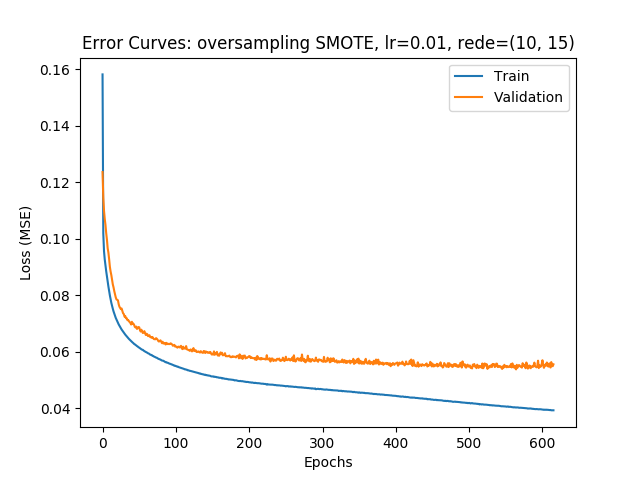

<IPython.core.display.Javascript object>


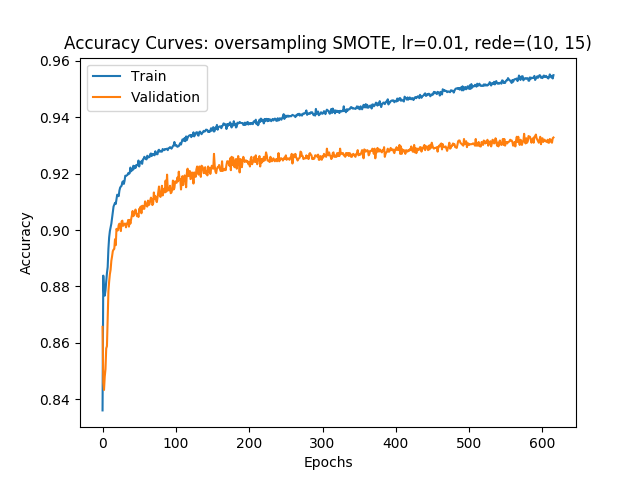

Matriz de confusão
[[1801   97]
 [   8   56]]

Train Loss:       0.0402
Validation Loss:  0.0537
Accuracy:         0.9465
MSE:              0.0535
AUROC:            0.9518


In [30]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history,graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [15]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.1868 - acc: 0.7807 - val_loss: 0.1342 - val_acc: 0.8633
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.0944 - acc: 0.8962 - val_loss: 0.1130 - val_acc: 0.8772
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.0847 - acc: 0.9052 - val_loss: 0.1084 - val_acc: 0.8812
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.0796 - acc: 0.9095 - val_loss: 0.1014 - val_acc: 0.8894
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.0765 - acc: 0.9153 - val_loss: 0.0993 - val_acc: 0.8938
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.0745 - acc: 0.9169 - val_loss: 0.0963 - val_acc: 0.8933
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.0730 - acc: 0.9194 - val_loss: 0.0956 - val_acc: 0.8970
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9413 - val_loss: 0.0863 - val_acc: 0.9017
Epoch 64/100000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9413 - val_loss: 0.0863 - val_acc: 0.9009
Epoch 65/100000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9423 - val_loss: 0.0861 - val_acc: 0.9020
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0523 - acc: 0.9427 - val_loss: 0.0871 - val_acc: 0.8988
Epoch 67/100000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9418 - val_loss: 0.0884 - val_acc: 0.8996
Epoch 68/100000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9422 - val_loss: 0.0868 - val_acc: 0.8996
Epoch 69/100000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9432 - val_loss: 0.0869 - val_acc: 0.8986
Epoch 70/100000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9430 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0477 - acc: 0.9502 - val_loss: 0.0941 - val_acc: 0.8907
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9501 - val_loss: 0.0928 - val_acc: 0.8930
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9502 - val_loss: 0.0941 - val_acc: 0.8901
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0475 - acc: 0.9505 - val_loss: 0.0934 - val_acc: 0.8915
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0475 - acc: 0.9503 - val_loss: 0.0938 - val_acc: 0.8925
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0475 - acc: 0.9497 - val_loss: 0.0939 - val_acc: 0.8909
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0474 - acc: 0.9498 - val_loss: 0.0939 - val_acc: 0.8912
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0474 - acc: 0.9501 - val_

7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9527 - val_loss: 0.0985 - val_acc: 0.8859
Epoch 188/100000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9522 - val_loss: 0.0991 - val_acc: 0.8857
Epoch 189/100000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9523 - val_loss: 0.0994 - val_acc: 0.8846
Epoch 190/100000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9532 - val_loss: 0.0987 - val_acc: 0.8844
Epoch 191/100000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9527 - val_loss: 0.0985 - val_acc: 0.8854
Epoch 192/100000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9531 - val_loss: 0.0991 - val_acc: 0.8859
Epoch 193/100000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9530 - val_loss: 0.0981 - val_acc: 0.8867
Epoch 194/100000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9526 - val_

7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9550 - val_loss: 0.1028 - val_acc: 0.8844
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0434 - acc: 0.9550 - val_loss: 0.1032 - val_acc: 0.8825
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0433 - acc: 0.9555 - val_loss: 0.1029 - val_acc: 0.8838
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0433 - acc: 0.9546 - val_loss: 0.1035 - val_acc: 0.8833
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9550 - val_loss: 0.1034 - val_acc: 0.8830
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9560 - val_loss: 0.1028 - val_acc: 0.8838
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9551 - val_loss: 0.1024 - val_acc: 0.8865
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0432 - acc: 0.9548 - val_

7592/7592 [==============================] - 0s - loss: 0.0420 - acc: 0.9575 - val_loss: 0.1076 - val_acc: 0.8844
Epoch 312/100000
7592/7592 [==============================] - 0s - loss: 0.0420 - acc: 0.9576 - val_loss: 0.1067 - val_acc: 0.8859
Epoch 313/100000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9582 - val_loss: 0.1058 - val_acc: 0.8846
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0420 - acc: 0.9577 - val_loss: 0.1095 - val_acc: 0.8817
Epoch 315/100000
7592/7592 [==============================] - 0s - loss: 0.0420 - acc: 0.9576 - val_loss: 0.1074 - val_acc: 0.8836
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0420 - acc: 0.9575 - val_loss: 0.1078 - val_acc: 0.8841
Epoch 317/100000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9576 - val_loss: 0.1087 - val_acc: 0.8825
Epoch 318/100000
7592/7592 [==============================] - 0s - loss: 0.0419 - acc: 0.9575 - val_

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.03725662444270559, 0.94852191629030658]


<IPython.core.display.Javascript object>


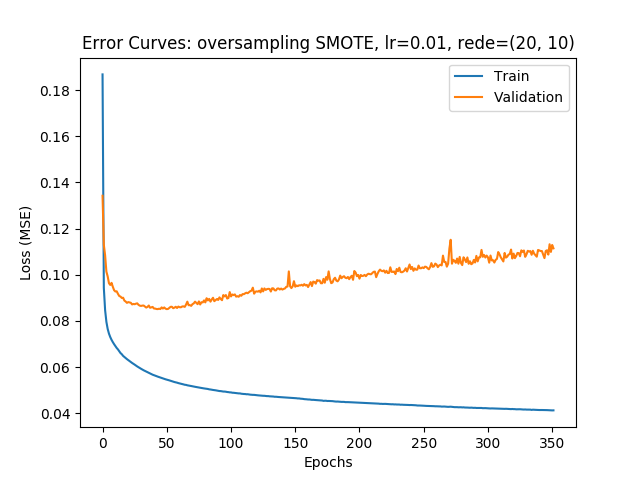

<IPython.core.display.Javascript object>


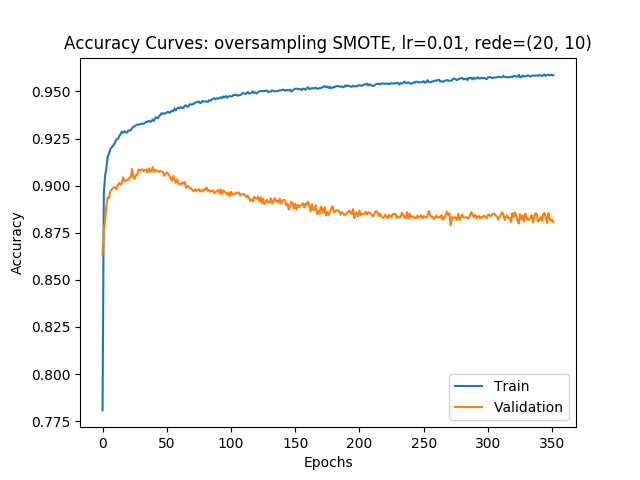

Matriz de confusão
[[1843   55]
 [  13   51]]

Train Loss:       0.0546
Validation Loss:  0.0851
Accuracy:         0.9653
MSE:              0.0347
AUROC:            0.9476


In [16]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(2)")
plot_training_acc_curves(history, graficoName + "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(4)")
plot_training_acc_curves(history, graficoName + "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))